# Introduction to Ensembling/Stacking in Python 

## Introduction

<span style="color:blue"> In [1]

In [1]:
# load in our libraries

import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking

from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, \
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.model_selection import KFold

pd.set_option('display.max_seq_items', None)

<span style="color:blue"> * KFold는 이제 cross_validation 모듈이 아니라 model_selection 모듈에 있음

## Feature Exploration, Engineering and Cleaning

먼저 현재 사용 중인 데이터를 탐색하고 가능한 피쳐 엔지니어링 기회를 식별하며 범주형 피쳐를 수치적으로 인코딩

<span style="color:blue"> ln [2]

pandas의 read_csv 사용하여 DF형식으로 파일 불러오기

In [2]:
# Load in the train and test datasets

train = pd.read_csv('./input/train.csv')
test = pd.read_csv('./input/test.csv')

test의 PassengerId 피처만 따로 PassengerId에 저장해둠

In [3]:
# Store our passenger ID for easy access

PassengerId= test['PassengerId']

train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


'./' : 현재경로

'../' : 현재경로에서 한 단계 전

### Feature Engineering

<span style="color:blue"> ln [3]

train과 test를 연결시켜 하나의 full_data로 만들어줌

In [4]:
full_data = [train, test]

train DF과 test DF 전체에 각각 apply(len) 적용하여 새로운 Name_length 피처 생성

In [5]:
# Some features of my own that I have added in
# Gives the length of the name

train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)

train DF과 test DF의 Cabin 피처에 apply lambda 함수에 if-else 구문을 적용하여, float type인 경우 0을, 그렇지 않을 경우, 1로 따져, 새로운 'Has_cabin' 피처 생성 

In [6]:
# Feature that tells whether a passenger had a cabin on the Titanic

train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

아까 train + test 해둔 full data를 한 행씩 돌면서 'SIbSp'피처와 'Parch'피처 값에 +1 한 값으로 새로운 'FamilySize' 피처 생성

(형제 자매 수 + 부모 자식 수 + 1(본인))

In [7]:
# Feature engineering steps taken from Sina
# Create new feature FamilySize as a combination of Sibsp and Parch

for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

먼저 'IsAlone'이라는 새로운 피처를 생성하고 0으로 초기화

loc로 인덱싱을 해줌

dataset의 'FamilySize'피처 값이 1인 행 중에서, 'IsAlone' 열만 인덱싱 후 그 값을 1로 변경

(FamilySize가 1인 경우, 본인 혼자인 경우이므로 IsAlone이 True라고 표현해준 것)

In [8]:
# Create new feature IsAlone from FamilySize

for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

full_data를 한 행씩 돌면서 'Embarked'피처의 결측값을 fillna를 사용해 'S'로 채워 넣음

In [9]:
# Remove all NULLS in the Embarked column

for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')

full_data를 한 행씩 돌면서 'Fare' 피처의 결측값을 fillna를 사용해 중간값으로 채워넣음

pandas의 qcut기능을 사용하여 train DF의 'Fare' 피처를 개수가 같게 4구간으로 나누고 새로운 'CategoricalFare'에 저장

In [10]:
# Remove all NULLS in the Fare column and create a new feature CategoricalFare

for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)

full_data를 한 행씩 돌면서 'Age'피처의 평균값과 표준편차값을 구해서 age_avg와 age_std에 저장

'Age'피처의 null값의 개수를 더해서 age_null_count에 저장

평균-편차값과 평균+편차 사이의 범위에서, null값의 개수(size) 만큼 난수를 생성하여 age_null_random_list에 저장

np.isnan으로 'Age'피처 중 결측값이 있는 인덱스를 찾아서 그 곳에 age_null_random_list 값을 넣어줌

전체 'Age'피처를 int형으로 변환

pd.cut을 사용해서 'Age'피처를 길이가 같게 5개의 카테고리로 나누어 새로운 'CategoricalAge'에 저장

In [11]:
# Create a New feature CategoricalAge

for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, \
                                            age_avg + age_std, \
                                            size = age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
train['CategoricalAge'] = pd.cut(train['Age'], 5)

이름의 title만 뽑아내는 get_title 함수 정의

' ([A-Za-z]+)\.'의 정규표현식과 search를 사용하여 가장 앞에 있는 영어 단어 + 온점까지를 title_search에 저장

그중 첫번째 group(영어부분)만 return

In [12]:
# Define function to extract titles from passenger names

def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    
    # If the title exists, extract and return it.
    
    if title_search:
        return title_search.group(1)
    return ""

full_data의 한 행씩 돌면서 'Name'피처에 get_title 함수 적용해서 뽑아낸 값을 새로운 피처'Title'에 저장

In [13]:
# Create a new feature Title, containing the titles of passenger names

for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)

'Title' 피처값이 주어진 값에 해당하는 경우 'Rare'로 변경

'Mlle', 'Ms'인경우 'Miss'로 변경

'Mne'인 경우 'Mrs'로 변경

In [14]:
# Group all non-common titles into one single grouping "Rare"

for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess', 'Capt', \
                                                'Col', 'Don', 'Dr', 'Major', 'Rev', \
                                                'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mne', 'Mrs')

피처들을 Mapping함

[Mapping sex]

성별의 경우, female은 0으로, male은 1로 설정한 후, int형으로 type 변경

[Mapping titles]

title 피처의 경우, 먼저 각 title당 숫자를 설정해놓은 title_mapping이라는 dictionary를 만들어두고, 그것에 맞게 mapping

결측값은 0으로 바꿔줌

[Mapping Embarked]

'Embarked' 피처의 경우, S는 0으로, C는 1로, Q는 2로 설정하고, int형변환

[Mapping Fare]

'Fare'피처의 경우 아까 qcut으로 나눈 4개의 구간을 각각 0,1,2,3으로 설정해주고 int형 변환

[Mapping Age]

'Age'피처의 경우 아까 cut으로 나눈 5개의 구간을 각각 0,1,2,3,4로 설정해주고 int형 변환

In [15]:
for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map({'female' : 0, 'male' : 1}).astype(int)
    
    # Mapping titles
    title_mapping = {'Mr' : 1, 'Miss' : 2, 'Mrs' : 3, 'Master' : 4, 'Rare' : 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map({'S' : 0, 'C' : 1, 'Q' : 2}).astype(int)
    
    # Mapping Fare
    dataset.loc[dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare'] = 2
    dataset.loc[dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[dataset['Age'] > 64, 'Age'] = 4

<span style="color:blue"> In [4]

drop_elements에 제거할 피처들을 리스트 형태로 만들어줌

해당 피처들을 drop해줌 (axis = 1, 열 제거)

이외에 train DF의 'CategoricalAge'피처와 'CategoricalFare'피처도 같은 방식으로 drop해줌

test DF도 drop_elements에 해당하는 피처들을 drop해줌

In [16]:
# Feature selection

drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
test = test.drop(drop_elements, axis = 1)

## Visualizations

<span style="color:blue"> In[5]

전처리이후의 train DF 확인

In [17]:
train.head(3)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1.0
1,1,1,0,2,0,3,1,51,1,2,0,3.0
2,1,3,0,1,0,1,0,22,0,1,1,2.0


### Pearson Correlation Heatmap

<span style="color:blue"> ln[6]

맷플롯립의 colormap 모듈 중 RdBu 옵션 선택

전체 그래프 사이즈는 14 * 12

그래프의 title은 'Pearson Correlation of Features로 설정하고 크기 15 (y=1.05는 모르겠음)

train DF의 값들을 float type으로 바꾼후, 각 피처끼리 상관관계를 히트맵으로 표현

[heatmap parameter]

- linewidths : 각 셀마다의 선의 굵기

- vmax : 색으로 표현하는 값의 최대값 (상관계수는 최대 1)

- square : 셀을 정사각형으로 출력

- cmap : 색 팔레트 옵션 설정 (colormap, RdBu)

- linecolor : 각 셀마다 선의 색

- annot : 셀의 값 표기 (True = O)

<AxesSubplot:title={'center':'Pearson Correlation of Features'}>

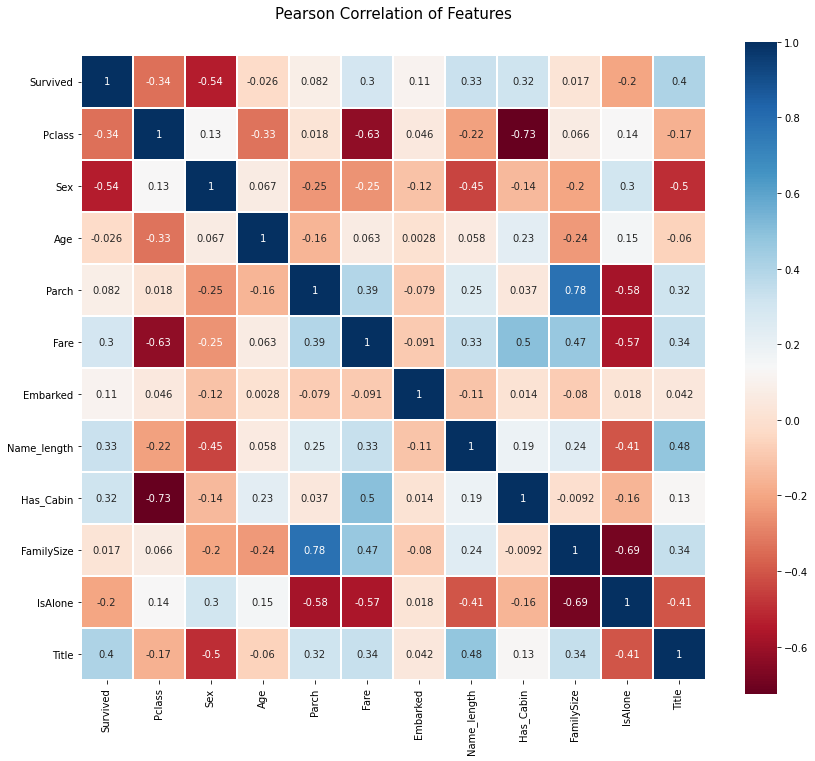

In [18]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(), linewidths=0.1, vmax=1.0, \
            square=True, cmap=colormap, linecolor='white', annot=True)

### Takeaway from the Plots

[heatmap 결과]

서로 강하게 상관되는 특징이 너무 많지는 않다는 것을 알 수 있습니다. 

이는 train set에 중복되거나 불필요한 데이터가 많지 않고 각 피처에 고유한 정보가 제공되었다는 의미.  

train set에 이러한 피처를 제공하는 것이 좋습니다. 

'Parch'와 'FamilySize' 피처가 0.78로 가장 상관관계가 높음.

이 연습의 목적을 위해 두 가지 피처들을 모두 사용하겠습니다.

### Pairplots

<span style="color:blue"> ln[7]

train DF의 해당 피처들을 넣어 pairplot을 그림

[pairplot parameter]

- hue : 그래프를 해당 옵션을 통해 구분해서 볼 수 있음. (빨강/파랑)

- palette : 색 팔레트 설정

- size : 크기 설정

- diag_kind='kde' : 각 변수별 커널밀도추정곡선 확인 가능 (밀도 플롯으로 출력)

- diag_kws : 각 그래프의 효과 설정 shade 줌

- plot_kws : 밀도함수의 원 크기 설정

set_xticklabels : tick에 표시되는 숫자 설정

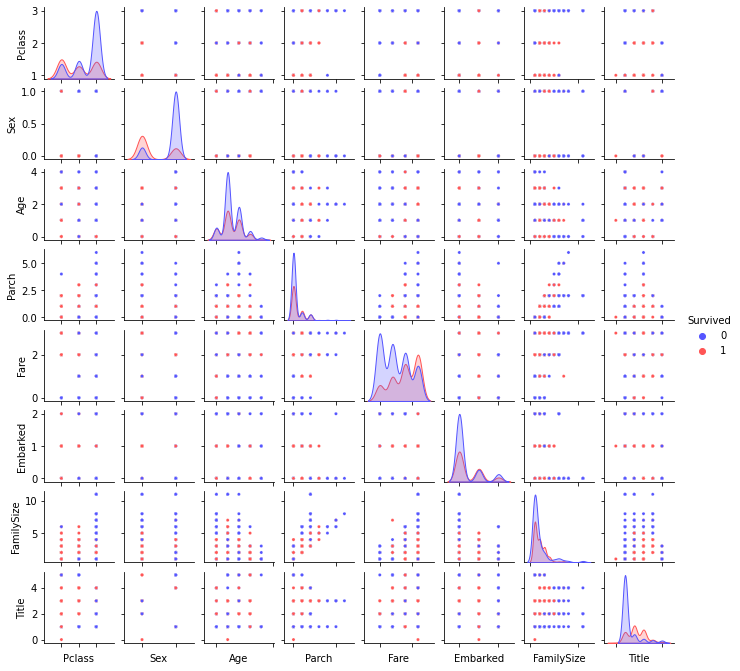

In [19]:
g = sns.pairplot(train[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch', \
                       u'Fare', u'Embarked', u'FamilySize', u'Title']], \
                hue='Survived', palette='seismic', size=1.2, diag_kind='kde', \
                diag_kws=dict(shade=True), plot_kws=dict(s=10))
g.set(xticklabels=[])

## Ensembling & Stacking models

Python 클래스를 통해 도우미를 찾습니다.
여기서는 Python의 클래스 사용을 호출하여 보다 편리하게 만듭니다. 프로그래밍을 처음 하는 사람에게는 일반적으로 클래스가 OOP(Object-Oriented Programming)와 함께 사용되는 것을 들을 수 있습니다. 즉, 클래스는 객체(구식 Peep용 변수)를 만들기 위한 일부 코드/프로그램을 확장하고 해당 클래스에 특화된 기능과 메소드를 구현하는 데 도움이 됩니다.

아래 코드 섹션에는 기본적으로 모든 Sklearn 분류기에 공통되는 내장 메서드(예: 열차, 예측 및 적합)를 확장할 수 있는 클래스 SklearnHelper를 작성합니다. 따라서 5개의 다른 분류자를 호출할 경우 동일한 메소드를 5번 작성할 필요가 없으므로 중복성이 사라집니다.

<span style="color:blue"> ln[8]

train과 test DF에 shape변수를 사용해서 데이터셋 개수를 각각 ntrain, ntest에 저장

SEED값은 0으로 NFOLDS값은 5로 초기화해주고, 그에 맞는 KFold 객체 생성

<span style="color:red"> KFold(ntrain, n_folds=NFOLDS, random_state=SEED)

In [20]:
# Some useful parameters which will come in handy later on

ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0
NFOLDS = 5
kf = KFold(n_splits=NFOLDS)

SklearnHelper라는 class 생성

(모든 Sklearn classifier에 공통되는 내장 메서드(예: 열차, 예측 및 적합)를 확장할 수 있는 클래스 SklearnHelper, 동일한 메서드를 폴드수만큼 작성할 필요가 없음)

초기화함수 ( clf(원하는 sklearn 분류기), 시드(랜덤 시드) 및 파라암(분류기 매개 변수)의 매개 변수를 제공)

train 함수 (train dataset으로 학습)

predict 함수 (x로부터 라벨 예측)

fit 함수 (모델을 fit 시키는 함수)

feature_importances 함수 (각 feature별로 개별 노드의 Gini importance를 합산하여 계수화 한 것)

In [21]:
# Class to extend the Sklearn classifier

class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)
    
# Class to extend XGboost classifer

### Out-of-Fold Predictions

<span style="color:blue"> ln[9]

OOF validation을 실행하는 사용자함수 get_oof 정의
    
<span style="color:red"> in enumerate(kf) -> in enumerate(kf.split(x_train))

**1. ntrain과 ntest에 각각 np.zeros를 해주어 oof_train과 oof_test에 저장 (ntrain 개수만큼의 요소를 가진 배열 off_train과 ntest 개수만큼의 요소를 가진 배열 off_test가 생성됨)**
    
(zeros() : 0으로 초기화된 shape 차원의 ndarray 배열 객체 반환)

**2. empty 사용해서 초기화하지 않은 채로 NFOLDS * ntest 개수만큼의 요소를 가진 배열을 oof_test_skf에 저장**

**3. 반복문 돌면서 각 인덱스에 맞는 값을 각각 x_tr, y_tr, x_te에 저장(각 classifier마다 5번씩 교차검증 진행)**

**4. x_tr과 y_tr 이용해서 학습시킴**

**5. x_te(폴드 세트 내부에서 다시 만들어진 검증 데이터)에 따른 예측결과를 oof_train에 index(test)에 맞게 저장**

**6. x_test(원본 테스트 데이터)에 따른 예측결과를 oof_test_skf에 저장 (fold수 x 예측값)**

**7. 3-6번을 다섯번 반복하고, 마지막에 oof_test_skf의 평균값을 oof_test에 저장(테스트 데이터로 저장)**

**8. oof_train과 off_test를 reshape하여 세로로 쭉 늘인형태로 만듦**

In [22]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain, ))
    oof_test = np.zeros((ntest, ))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf.split(x_train)):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]
        
        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)

    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

## Generating our Base First-Level Models 

first level classification을 위해 five learning model을 준비

1. Random Forest classifier

2. Extra Trees classifier

3. AdaBoost classifier

4. Gradient Boosting classifier

5. Support Vector Machine

<span style="color:blue"> In [10]

각 classifier의 parameter 설정

- n_jobs : training process에 사용되는 코어 수입니다. -1로 설정하면 모든 코어가 사용됨

- n_estimators : 학습 모델의 분류 트리 수입니다(기본값당 10으로 설정)

- max_depth : 트리의 최대 깊이 또는 노드를 확장할 크기, 너무 높게 설정하면 나무가 너무 깊게 자라 과적합될 위험이 있으므로 주의

- verbose : 학습 프로세스 중에 텍스트를 출력할지 여부를 제어, 값이 0이면 모든 텍스트가 표시되지 않고 값이 3이면 반복할 때마다 트리 학습 프로세스가 출력됨

- min_samples_leaf : 리프노드가 되기 위해 필요한 최소한의 샘플 데이터수, 과적합 제어 용도, 불균형 데이터의 경우 특정 클래스의 데이터가 극도로 작을 수 있으므로 작게 설정 필요

- max_features : 최적의 분할을 위해 고려할 최대 feature 개수 (max_features : sqrt는 전체 피처 중 √(피처개수)만큼 선정한다는 의미)

- learning_rate : 학습을 진행할 때마다 적용하는 학습률(0~1), Weak learner가 순차적으로 오류 값을 보정해나갈 때 적용하는 계수 (Default = 1.0)

- kernel : decision boundary의 모양을 선형으로 할지 다항식형으로 할지 등을 결정 (linear -> 선형)

- C : C는 training data를 정확히 구분할지 아니면 decision boundary를 일반화할지를 결정해줍니다. 결론적으로 C가 크면 decision boundary는 더 굴곡지고, C가 작으면 decision boundary는 직선에 가깝습니다.

In [23]:
# Put in our parameters for said classifiers
# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
    }

<span style="color:blue"> ln[11]

각 classifier마다 SklearnHelper 객체 생성

In [24]:
# Create 5 objects that represent our 4 models
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

### Creating NumPy arrays out of our train and test sets

원래 DF에서 NumPy array를 생성하여 classifier에 입력할 train 및 test 데이터를 준비

ravel() 사용하여 다차원배열을 1차원배열로 평평하게 만들어줌

train DF의 'Survived'피처만 y_train에 넣어주고 drop시킴

x_train에 나머지 피처들 넣어줌

x_test에는 test DF의 전체 피처 넣어줌

<span style="color:blue"> In [12]

In [25]:
# Create Numpy arrays of train, test and target ( Survived) dataframes to feed into our models
y_train = train['Survived'].ravel()
train = train.drop(['Survived'], axis=1)
x_train = train.values # Creates an array of the train data
x_test = test.values # Creats an array of the test data

### Output of the First level Predictions

<span style="color:blue"> In [13]

각 classfier마다 get_oof 함수 실행(교차검증이 5 * 5번 일어남)

In [26]:
# Create our OOF train and test predictions. These base results will be used as new features
rf_oof_train, rf_oof_test = get_oof(rf, x_train, y_train, x_test) # Random Forest
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) # Extra Trees
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb, x_train, y_train, x_test) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc, x_train, y_train, x_test) # Support Vector Classifier

print("Training is complete")

Training is complete


### Feature importances generated from the different classifiers

<span style="color:blue"> In [14]

feature_importances사용해서 피처중요도 추출

In [27]:
rf_feature = rf.feature_importances(x_train,y_train)
et_feature = et.feature_importances(x_train, y_train)
ada_feature = ada.feature_importances(x_train, y_train)
gb_feature = gb.feature_importances(x_train,y_train)

[0.12590419 0.20370911 0.03155444 0.02138713 0.07272408 0.02412844
 0.1065782  0.06620289 0.06646978 0.01311023 0.2682315 ]
[0.12161783 0.39044176 0.03018516 0.01658115 0.05746396 0.02795388
 0.04785912 0.0837726  0.04292763 0.02114215 0.16005477]
[0.028 0.008 0.012 0.064 0.04  0.01  0.694 0.014 0.054 0.002 0.074]
[0.08448052 0.01067642 0.05233816 0.01421199 0.05425904 0.02285408
 0.17767273 0.04100823 0.11047229 0.00715557 0.42487098]


<span style="color:blue"> In [15]

위에 결과로 나온 피처 중요도 그대로 복사해서 저장

In [28]:
rf_features = [0.12597284, 0.20551491, 0.03367072, 0.02105394, 0.07216639, 0.02507346,
 0.10784502, 0.06614842, 0.06427352, 0.01362809, 0.26465271]
et_features = [0.12302603, 0.39079371, 0.03014544, 0.01652193, 0.05493474, 0.02782305,
 0.04859922, 0.08415278, 0.04422093, 0.02150615, 0.15827602]
ada_features = [0.032, 0.01, 0.022, 0.064, 0.036, 0.01, 0.686, 0.014, 0.048, 0.006, 0.072]
gb_features = [0.08653621, 0.01319158, 0.04841019, 0.0127774,  0.05138346, 0.02751263,
 0.17798015, 0.03660041, 0.11270645, 0.00636601, 0.4265355 ]

<span style="color:blue"> In [16]

train DF의 칼럼값을 cols에 넣어줌

각 피처들이 들어있는 DF인 feature_dataframe 생성

In [29]:
cols = train.columns.values
# Create a dataframe with features
feature_dataframe = pd.DataFrame( {'features': cols,
     'Random Forest feature importances': rf_features,
     'Extra Trees  feature importances': et_features,
      'AdaBoost feature importances': ada_features,
    'Gradient Boost feature importances': gb_features
    })

### Interactive feature importances via Plotly scatterplots

<span style="color:blue"> In [17]

피처 중요도값을 산점도 그래프로 나타냄


x값은 각 피처의 값
y값은 각 classfier의 중요도 값

mode='markers' : Scatter Plot을 그리기 위해 Markers

marker=dict : Marker에 대한 세부적인 설정을 지정

- sizemode : 지름으로 설정
 
- sizeref :  

- size : 점 크기

- color : 색깔 값을 중요도값에 따라 변하도록 설정

- colorscale : colorscale type 'Portland'로 지정

- showscale=True : colorscales 보여줌

text에는 피처 저장

trace에서 저장한 값들 data에 한번에 저장

layout은 go.Layout으로 설정

autosize=True / title / hovermode

yaxis=dict

- title : y축 label

- ticklen : 글씨 두께

- gridwidth

showlegend = False : 범례 추가

fig = go.Figure(data=data, layout=layout) : data와 layout에 맞춰 그래프그리기

py.iplot(fig,filename='scatter2010')

In [30]:
# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Random Forest feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Random Forest feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Random Forest Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

In [31]:
# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Extra Trees  feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Extra Trees  feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Extra Trees Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

In [32]:
# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['AdaBoost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['AdaBoost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'AdaBoost Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')


In [33]:
# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Gradient Boost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Gradient Boost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Gradient Boosting Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

<span style="color:blue"> In [18]

피처 중요도의 평균을 계산하여 feature_dataframe에 새 피처 'mean'으로 저장

In [34]:
# Create the new column containing the average of values

feature_dataframe['mean'] = feature_dataframe.mean(axis= 1) # axis = 1 computes the mean row-wise
feature_dataframe.head(3)

,features,Random Forest feature importances,Extra Trees feature importances,AdaBoost feature importances,Gradient Boost feature importances,mean
0,Pclass,0.125973,0.123026,0.032,0.086536,0.091884
1,Sex,0.205515,0.390794,0.010,0.013192,0.154875
2,Age,0.033671,0.030145,0.022,0.048410,0.033557


### Plotly Barplot of Average Feature Importances

<span style="color:blue"> In [19]

이번엔 filename='bar-direct-labels'로 설정해서 barplot 그리기

x값에 피처, y값에 중요도 평균값

data, layout 파라미터 설정 후 그래프 그리기

In [35]:
y = feature_dataframe['mean'].values
x = feature_dataframe['features'].values
data = [go.Bar(
            x= x,
             y= y,
            width = 0.5,
            marker=dict(
               color = feature_dataframe['mean'].values,
            colorscale='Portland',
            showscale=True,
            reversescale = False
            ),
            opacity=0.6
        )]

layout= go.Layout(
    autosize= True,
    title= 'Barplots of Mean Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='bar-direct-labels')

## Second-Level Predictions from the First-level Output

### First-level output as new features

<span style="color:blue"> In [20]

classfier train

각 train 값들을 다차원에서 1차원 ravel 이용해서 풀어준 후 출력

In [36]:
base_predictions_train = pd.DataFrame( {'RandomForest': rf_oof_train.ravel(),
     'ExtraTrees': et_oof_train.ravel(),
     'AdaBoost': ada_oof_train.ravel(),
      'GradientBoost': gb_oof_train.ravel()
    })
base_predictions_train.head()

,RandomForest,ExtraTrees,AdaBoost,GradientBoost
0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0
2,0.0,0.0,1.0,1.0
3,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0


### Correlation Heatmap of the Second Level Training set

<span style="color:blue"> In [21]

z = 상관계수 값
x, y = base_predictions_train의 값

- colorscale : Viridis에 따라

- showscale=True : colorscale 보여주기

- reversescale=True : 값이 클수록 진한 파랑, 값이 작을수록 노란색에 가깝게

In [37]:
data = [
    go.Heatmap(
        z= base_predictions_train.astype(float).corr().values ,
        x=base_predictions_train.columns.values,
        y= base_predictions_train.columns.values,
          colorscale='Viridis',
            showscale=True,
            reversescale = True
    )
]
py.iplot(data, filename='labelled-heatmap')

<span style="color:blue"> In [22]

concatenate 사용해서 다음 배열들을 합쳐 각각 x_train과 x_test로 둠(앙상블)

In [38]:
x_train = np.concatenate(( et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train), axis=1)
x_test = np.concatenate(( et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test), axis=1)

### Second level learning model via XGBoost

<span style="color:blue"> In [23]

XGBoost 모델링

- n_estimators : 학습 모델의 분류 트리 수입니다(기본값당 10으로 설정)

- max_depth : 트리를 얼마나 깊게 만들 것인지 나타냄. 숫자를 너무 높게 설정하면 과적합될 위험이 있으므로 주의

- min_child_weight : child의 관측에서 요구되는 최소 가중치의 합. over-fitting vs under-fitting을 조정하기 위한 파라미터. 너무 큰 값이 주어지면 under-fitting.

- gamma : 트리의 리프 노드에서 추가 파티션을 만드는 데 필요한 최소 손실 감소입니다. 크기가 클수록 알고리즘은 더 보수적일 것입니다.

- subsample : 각 트리마다의 관측 데이터 샘플링 비율. 값을 적게 주면 over-fitting을 방지하지만 값을 너무 작게 주면 under-fitting. 일반적으로 0.5-1

- colsample_bytree : 각 트리마다의 feature 샘플링 비율.

- objective='binary:logistic' : 이진 분류를 위한 로지스틱 회귀, 예측된 확률을 반환

- nthread : XGBoost를 실행하기 위한 병렬처리(쓰레드) 개수 (n_jobs)

- scale_pos_weight : 이는 상대적으로 적은 클래스를 잘못 분류하는 것에 대한 패널티를 부여해서 모델 성능 높여줌

그렇게 XGB 객체 생성 후 fit, predict 해줌

예측값은 prediction에 저장

In [39]:
gbm = xgb.XGBClassifier(
    #learning_rate = 0.02,
 n_estimators= 2000,
 max_depth= 4,
 min_child_weight= 2,
 #gamma=1,
 gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1).fit(x_train, y_train)
predictions = gbm.predict(x_test)

[14:37:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


### Producing the Submission file

<span style="color:blue"> In [24]

이전에 미리 저장해둔 PassengerId를 PassengerId 피처로, 예측값을 Survived 피처로해서 새로운 DF 생성하고 파일 생성

In [40]:
# Generate Submission File 
StackingSubmission = pd.DataFrame({ 'PassengerId': PassengerId,
                            'Survived': predictions })
StackingSubmission.to_csv("./output/StackingSubmission.csv", index=False)